In [1]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
from scipy.optimize import minimize, root
from functools import partial
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt

In [2]:
# open dataset
df = pd.read_stata("../data/dataset_stat_ret_age_expectations.dta").astype(float)

In [3]:
# add columns for mean and stdev
df["mu"] = 0
df["sigma"] = 0
df["ex_val"] = 0
df["var"] = 0
df["error_1"] = 0
df["error_2"] = 0

In [4]:
# das wird später noch eleganter
options = {
    "ll": 66.5,
    "ul": 80,
    "first_cdf_point": 67.5,
    "second_cdf_point": 68.5,
}

In [5]:
# objective function to be minimized
def objective(params, options):
    mu, sigma = params
    # mu = params
    # sigma = 1 #TEST
    a, b = (options["ll"] - mu) / sigma, (options["ul"] - mu) / sigma

    # Calculate CDF values from the truncated normal distribution
    predicted_cdf_1 = truncnorm.cdf(
        x=options["first_cdf_point"], a=a, b=b, loc=mu, scale=sigma
    )
    predicted_cdf_2 = truncnorm.cdf(
        x=options["second_cdf_point"], a=a, b=b, loc=mu, scale=sigma
    )
    # Calculate the squared differences
    error_1 = (options["observed_cdf_67_5"] - predicted_cdf_1) ** 2
    error_2 = (options["observed_cdf_68_5"] - predicted_cdf_2) ** 2
    # Sum of squared differences
    # total_error = error_1 + error_2
    return np.array([error_1, error_2])

In [6]:
for index, row in df.iterrows():
    # observed CDF values
    options["observed_cdf_67_5"] = row["pol_unc_stat_ret_age_67"] / 100  # CDF(67.5)
    options["observed_cdf_68_5"] = (
        row["pol_unc_stat_ret_age_68"] + row["pol_unc_stat_ret_age_67"]
    ) / 100  # CDF(68.5)

    if row["pol_unc_stat_ret_age_67"] == 100:
        df.at[index, "ex_val"] = 67
        df.at[index, "var"] = 0
    elif row["pol_unc_stat_ret_age_68"] == 100:
        df.at[index, "ex_val"] = 68
        df.at[index, "var"] = 0
    elif row["pol_unc_stat_ret_age_69"] == 100:
        # Mean of last interval
        df.at[index, "ex_val"] = 74.25
        # Variance of uniform distribution between start of last
        # interval and upper limit
        df.at[index, "var"] = ((80 - 68.5) ** 2) / 12
    else:
        # initial guess for mean and variance
        initial_guess = [68, 1]
        # initial_guess = 68
        partial_obj = partial(objective, options=options)

        # perform optimization
        # result = minimize(partial_obj, initial_guess, method='BFGS')
        result = root(fun=partial_obj, x0=initial_guess)

        # collect results
        mean, stdev = result.x
        # mean =  result.x #TEST
        # stdev = 1 #TEST
        df.at[index, "mu"] = mean
        df.at[index, "sigma"] = stdev
        df.at[index, "error_1"], df.at[index, "error_2"] = result.fun

        # calculate expected value
        a, b = (options["ll"] - mean) / stdev, (options["ul"] - mean) / stdev
        exval, var = truncnorm.stats(a, b, loc=mean, scale=stdev, moments="mv")
        df.at[index, "ex_val"] = exval
        df.at[index, "var"] = var

    # print(index)

In [7]:
exog_1 = np.array([np.ones(df.shape[0]), df["birth_year"].values]).T

<Axes: xlabel='birth_year'>

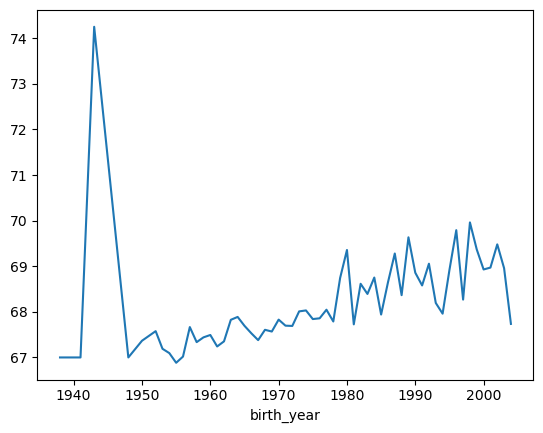

In [8]:
df.groupby("birth_year")["ex_val"].mean().plot()

In [9]:
OLS(exog=exog_1, endog=df["var"].values).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     43.21
Date:                Sat, 23 Sep 2023   Prob (F-statistic):           9.41e-11
Time:                        14:32:22   Log-Likelihood:                -1797.0
No. Observations:                 728   AIC:                             3598.
Df Residuals:                     726   BIC:                             3607.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -100.8059     15.573     -6.473      0.000    -131.380     -70.232
x1             0.0518      0.008      6.573      0.000       0.036       0.067
==============================================================================
Omnibus:                      449.782   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2939.722
Skew:                           2.899   Prob(JB):                         0.00
Kurtosis:                      10.956   Cond. No.                     2.91e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.91e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
OLS(exog=exog_1, endog=df["ex_val"].values).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     83.29
Date:                Sat, 23 Sep 2023   Prob (F-statistic):           6.88e-19
Time:                        14:32:22   Log-Likelihood:                -1345.0
No. Observations:                 728   AIC:                             2694.
Df Residuals:                     726   BIC:                             2703.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.2422      8.371     -0.985      0.325     -24.676       8.192
x1             0.0386      0.004      9.126      0.000       0.030       0.047
==============================================================================
Omnibus:                      420.920   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2632.092
Skew:                           2.671   Prob(JB):                         0.00
Kurtosis:                      10.631   Cond. No.                     2.91e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.91e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""